# Homework 1: Missing Data and inverse propensity weighting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
import matplotlib.pyplot as plt

from tools import KangSchafSampler, get_estimator_stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/home/adong/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Kang & Schafer Simulated Dataset

The sampling distribution provided in `sampler.py` (KangSchafSampler) was based on Kang and Schafer's [Demystifying Double Robustness: A Comparison of Alternative Strategies for Estimating a Population Mean from Incomplete Data](https://projecteuclid.org/download/pdfview_1/euclid.ss/1207580167) in Section 1.4. They describe the motivation for the simulated dataset in the discussion at the end:

>"We constructed our simulation to vaguely resemble a quasi-experiment to measure the effect of
dieting on body mass index (BMI) in a large sample of high-school students. The study has a pre-post
design. Covariates $x_i$ measured at baseline include
demographic variables, BMI, self-perceived weight
and physical fitness, social acceptance and personality measures. The treatment $t_i$ is dieting (0 = yes, 1 =
no) and the outcome $y_i$ is BMI one year later. The goal
is to estimate an average causal effect of dieting among
those who actually dieted. For that purpose, it suffices
to treat the dieters as nonrespondents, set their BMI
values to missing, and apply a missing-data method
to estimate what the mean BMI for this group would
have been had they not dieted."

In terms of the missing data and response bias problem that we've been studying, Kang and Schafer are interested in the situation where we are not given the propensity scores of our observations, but rather we have to estimate the propensity score function from data using a model.  They consider two cases: 1) The model we're fitting is "correct", in the sense that the true propensity score function is in the parameterized set of functions of our model. In machine learning terminology, we would just say that the hypothesis space has 0 approximation error. 2) The model we're fitting is "incorrect", in the sense that the true propensity score function is not in our model (i.e. there is nonzero approximation error). 

To simulate these two cases, they create a simple data generating distribution where each response $y$ is an affine function of a covariate vector $z$, plus Gaussian noise.  Similarly, the response probability is determined by a logistic regression model on $z$:
* Covariate: $z=(z_1, z_2, z_3, z_4) \sim N(0, I_{4x4})$
* Response: $y = 210 + 27.4z_1 + 13.7z_2 + 13.7z_3 + 13.7z_4 + \epsilon$ where $\epsilon \sim N(0,1)$
* Propensity: $\pi = expit(-z_1 + 0.5z_2 - 0.25z_3 - 0.1z_4)$ which is called `obs_prob` in code below
* $r = Bernoull(\pi)$ is the response indicator, which is called `obs` in code below

Using logistic regression on $z$ would be a "correct" model in this case. To simulate an "incorrect" model, they introduce a new covariate $x=(x_1, x_2, x_3, x_4)$, which is a complicated nonlinear transform of $z$.  (See `transform_z` from `KangSchafSampler.get_x` in tools.py for the explicit mapping -- although in "real life" you would not know this transform function.) They then investigate using logistic regression on $x$ to model the propensity score function.  This is clearly an "incorrect" model, since logistic regression has a linear dependence on $x$, while the true model has a nonlinear dependence on $x$.

In the notebook below, we'll compare using incorrect and correct models in this setting, and we'll also see if we can improve the situation by using modern nonlinear ML models for the propensity function based on $x$.

For our sampling distribution:
* Overall mean of y = 210
* Mean of observed y = 200 
* Mean of missing y = 220
* Response rate = 0.5

Our goal below is to use the observed data to estimate the overall mean of y.  We'll evaluate performance using RMSE between our estimates and 210, which we know to be the actual overall mean.  

To start our investigation, we'll visualize the distribution of each component of $x$ for the complete and incomplete cases (corresponding to `obs=True` and `obs=False`.

In [3]:
sampler = KangSchafSampler(rng=default_rng(27))
s = sampler.sample(n=200)
s.head() 

,z1,z2,z3,z4,x1,x2,x3,x4,obs_prob,obs,y
0,1.254448,0.776902,0.964881,-1.082178,1.872406,10.172419,0.272622,387.882139,0.269138,True,252.441072
1,0.867017,-0.168161,-0.189661,1.120566,1.542661,9.950245,0.208974,439.003304,0.265858,True,244.895501
2,-0.436779,-1.279645,-0.469500,-1.196827,0.803812,9.222627,0.224981,307.074015,0.508503,False,156.990005
3,-1.839857,-0.145557,0.398279,-2.162061,0.398548,9.874394,0.185865,313.020372,0.868037,False,133.941012
4,0.014477,0.255198,0.173191,-1.270094,1.007265,10.126675,0.216108,360.434196,0.549050,False,197.966340


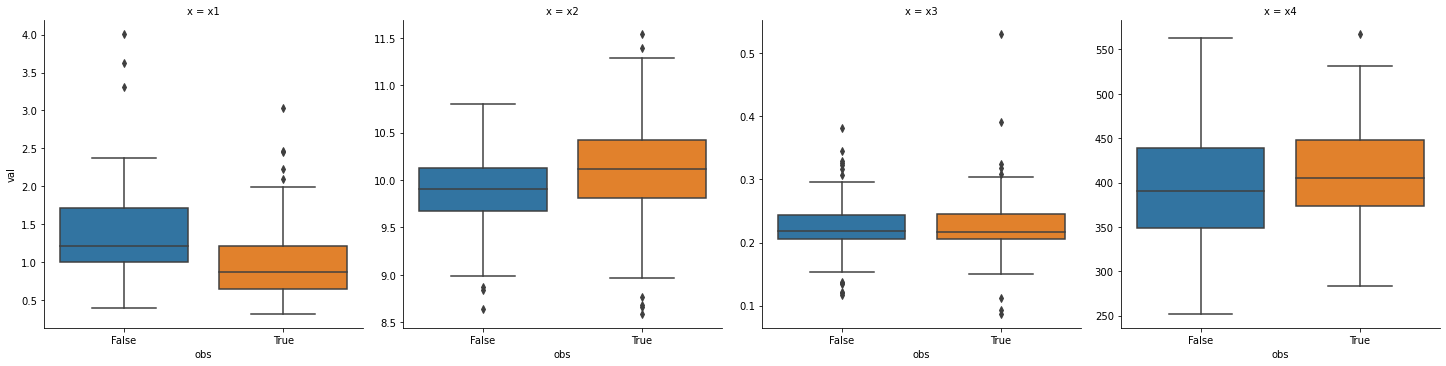

In [4]:
df_long = pd.melt(s[['x1', 'x2', 'x3', 'x4', 'obs']], "obs", var_name="x", value_name="val")
g = sns.catplot(x="obs", y="val", col="x", data=df_long, kind="box", sharey=False)

From the box plot, we can see from the $x_1$ plot, in particular, that values are not missing completely at random.  This justifies the additional complexity of using estimators for the MAR setting, rather than just a complete-case estimator.

### Problem 1

**PART A:** Create a function that calculates the IPW and self-normalized IPW mean estimators from a sample. Additionally, include a total of the weights associated to *observed* outcomes. We will use this function below. 

In [5]:
def ipw_estimators(obs_prob, obs, outcome):
    """
    
    Args:
        obs_prob (pd.Series): probabilities that y_i were observed (i.e. propensities)
        obs (pd.Series): boolean series that tells whether value was observed or not
        outcome (pd.Series): the measurement of the outcome y_i
    
    Returns:
        dict: {'ipw': ipw, 'sn_ipw': sn_ipw, 'total_weight': total_weight}
    """
    ipw = outcome.dot(obs.divide(obs_prob))/len(outcome)
    sn_ipw = outcome.dot(obs.divide(obs_prob))/( (1/ obs_prob).dot(obs))
    total_weight = (1/obs_prob).sum()
    
    return {'ipw': ipw,
            'sn_ipw':sn_ipw,
            'total_weight':total_weight}

**PART B:** Run 1000 trials of the following: 1) Draw a sample `sample_size=200` from the sampler defined above. 2) Get the ipw and sn_ipw estimates of the overall mean using the `ipw_estimators()` function you created above.  For this simulation, use the true propensities for each observation, which are given in the `obs_prob` column of the dataframe returned by the sampler. Collect all these results into a dataframe. So that we can use the `get_estimator_stats` function below, each row of the resulting dataframe should correspond to a single trial and each column should correspond to an estimator (either ipw or sn_ipw).

In [6]:
ipw_list = []
sn_ipw_list = []
total_weight_list = []
for ii in range(1000):
    sampler = KangSchafSampler(rng=default_rng())
    s = sampler.sample(n=200)
    result = ipw_estimators(s['obs_prob'],s['obs'],s['y'])
    ipw_list.append(result['ipw'])
    sn_ipw_list.append(result['sn_ipw'])
    total_weight_list.append(result['total_weight'])
results_df = pd.DataFrame(
    {'ipw': ipw_list,
     'sn_ipw': sn_ipw_list,
     'total_weight': total_weight_list
    })

In [7]:
results_df

,ipw,sn_ipw,total_weight
0,215.323105,211.563664,633.005394
1,168.073860,203.783789,548.353919
2,216.697006,210.338971,607.136399
3,206.102212,208.507789,571.013841
4,158.329107,203.987763,629.403961
...,...,...,...
995,260.065225,217.885148,644.857162
996,206.553035,213.096544,593.290689
997,194.774424,202.734324,550.236708
998,198.078138,206.910160,555.050226


**PART C:** Compute the bias, variance, and RMSE of the IPW and the self-normalized IPW estimators using `get_estimator_stats` from tools.py (already imported). Briefly summarize your findings.

In [8]:
stat_df = get_estimator_stats(results_df,true_mean=210)
stat_df

,stat,mean,SD,SE,bias,RMSE
0,ipw,209.676698,23.529349,0.744063,-0.323302,23.531570
1,sn_ipw,209.757597,4.919545,0.155570,-0.242403,4.925514
2,total_weight,588.832427,44.776625,1.415961,378.832427,381.469466


**PART D:** Show that for the ipw estimator, the estimates of SD, bias, and RMSE are compatible in terms of the bias-variance decomposition identity.

In [9]:
#RMSE = sqrt(bias^2 + SD^2)
RMSE = ((stat_df['mean'][0]-210)**2 + stat_df['SD'][0]**2)**.5
print(RMSE)
print(stat_df['RMSE'][0])

23.53156994766532
23.531569947665314


### Problem 2

**PART A:** Graph the scatterplot of the IPW estimate vs total_weight across trials recorded in the results dataframe from Problem 1. *Do the same* for the self-normalized IPW estimate.  Report the correlation for each. Briefly describe your findings.

                   ipw    sn_ipw  total_weight
ipw           1.000000  0.650375      0.009428
sn_ipw        0.650375  1.000000      0.225680
total_weight  0.009428  0.225680      1.000000


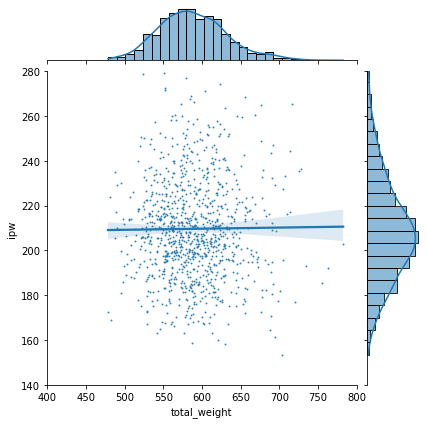

In [10]:
sns.jointplot(data=results_df, x='total_weight', y='ipw', kind="reg", x_jitter=0, scatter_kws={"s": 1})
print(results_df.corr())
plt.ylim(140,280)
plt.xlim(400,800)
plt.show()

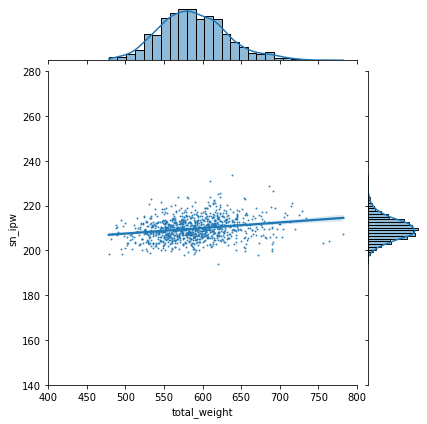

In [11]:
sns.jointplot(data=results_df, x='total_weight', y='sn_ipw', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140,280)
plt.xlim(400, 800)
plt.show()

### Problem 3

In the previous problems, we used the true propensities that our dataset generator provided us in the (`obs_prob`) column. In this problem, we'll investigate the impact of estimating the propensity score function from data, both for a "correct" model and an "incorrect" model.  

**PART A:** Following the pattern in Problems 1.B and 1.C above, compare the performance of the IPW estimator using the true propensities to the performance using propensities predicted by a logistic regression model fit to the $z_i$'s. Also compare to a logistic regression model fit to the $x_i$'s.  Repeat the comparison for the self-normalized IPW estimator. Summarize your findings. [Hint: Figuring out a good naming convention for these estimators is no joke.  We like to use ipw_t for IPW using the true propensities, ipw_lr_x for IPW using a logistic regression estimate of propensity with the $x_i$ covariates.  Then sn_ipw_rf_z when we're using self-normalized IPW with a random forest propensity model based on covariate $z$.]

In [12]:
@ignore_warnings(category=ConvergenceWarning)
def total_predicted_weight(s):
#Create X and y for Logisitic Regression DF
    #print('model_for_z')
    obs = s['obs']
    covariates=s[['z1','z2','z3','z4']]
    model = LogisticRegression(fit_intercept=True)
    model.fit(X=covariates,y=obs)
    true_index = np.where(model.classes_ == True)[0][0]
    pred_prop_z = model.predict_proba(X=covariates)[:,true_index]

    #print('model_for_x')

    obs = s['obs']
    covariates=s[['x1','x2','x3','x4']]
    model = LogisticRegression(fit_intercept=True)
    model.fit(X=covariates,y=obs)
    true_index = np.where(model.classes_ == True)[0][0]
    pred_prop_x = model.predict_proba(X=covariates)[:,true_index]
    
    return pred_prop_z, pred_prop_x


In [13]:
ipw_t_list = []
sn_ipw_t_list = []
total_weight_t_list = []
ipw_z_list = []
sn_ipw_z_list = []
total_weight_z_list = []
ipw_x_list = []
sn_ipw_x_list = []
total_weight_x_list = []
for ii in range(1000):
    sampler = KangSchafSampler(rng=default_rng())
    s = sampler.sample(n=200)
    
    pred_prop_z, pred_prop_x = total_predicted_weight(s)
    # True Weight
    result = ipw_estimators(s['obs_prob'],s['obs'],s['y'])
    ipw_t_list.append(result['ipw'])
    sn_ipw_t_list.append(result['sn_ipw'])
    total_weight_t_list.append(result['total_weight'])
    
    # Weight estimated from Z
    result = ipw_estimators(pd.Series(pred_prop_z),s['obs'],s['y'])
    ipw_z_list.append(result['ipw'])
    sn_ipw_z_list.append(result['sn_ipw'])
    total_weight_z_list.append(result['total_weight'])
    
    #Weight estimated from X
    result = ipw_estimators(pd.Series(pred_prop_x),s['obs'],s['y'])
    ipw_x_list.append(result['ipw'])
    sn_ipw_x_list.append(result['sn_ipw'])
    total_weight_x_list.append(result['total_weight'])
    
    
    
results_df = pd.DataFrame(
    {'ipw_t': ipw_t_list,
     'sn_ipw_t': sn_ipw_t_list,
     'total_weight_t': total_weight_t_list,
     'ipw_z': ipw_z_list,
     'sn_ipw_z': sn_ipw_z_list,
     'total_weight_z': total_weight_z_list,
     'ipw_x': ipw_x_list,
     'sn_ipw_x': sn_ipw_x_list,
     'total_weight_x': total_weight_x_list,
    })

In [14]:
results_df

,ipw_t,sn_ipw_t,total_weight_t,ipw_z,sn_ipw_z,total_weight_z,ipw_x,sn_ipw_x,total_weight_x
0,180.710808,204.828043,573.859322,193.240515,206.347001,1064.744563,195.107560,206.416090,1713.901997
1,271.946754,215.442781,599.829523,209.298298,210.020126,393.833775,206.666893,208.573097,420.660410
2,206.226466,212.918680,682.373402,215.642077,213.964979,764.497213,220.607516,212.281991,774.871311
3,205.676021,213.509155,553.734277,250.869241,217.389370,732.918976,258.993253,217.515694,605.560045
4,220.955652,205.083363,574.444797,200.451218,204.365675,470.753196,198.844416,203.098860,473.524079
...,...,...,...,...,...,...,...,...,...
995,219.769351,210.002561,541.504075,203.966940,209.429030,478.823937,202.541758,208.448185,582.912255
996,202.081945,207.551634,523.498544,204.588382,209.096079,567.703120,211.992016,208.901769,528.431501
997,217.130895,211.977543,647.835943,202.108433,208.551674,560.186897,195.327035,206.848768,584.373263
998,198.474253,207.757305,586.702581,200.215274,206.499133,592.281533,199.688677,206.082360,4616.062088


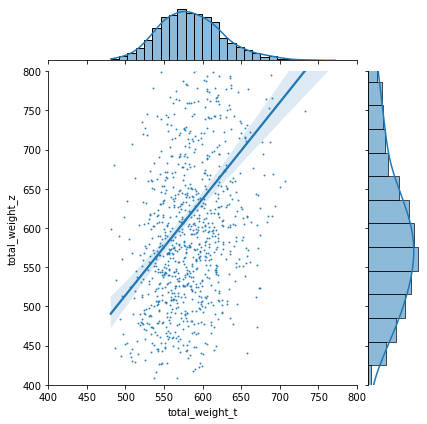

In [15]:
sns.jointplot(data=results_df, x='total_weight_t', y='total_weight_z', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(400, 800)
plt.xlim(400, 800)
plt.show()


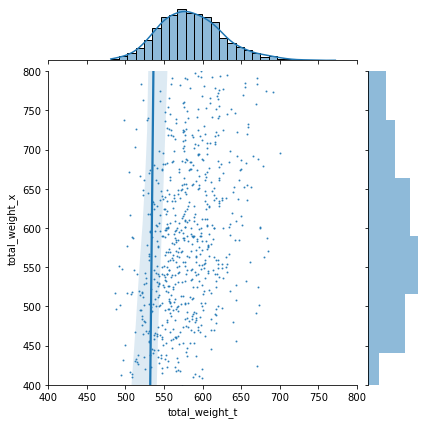

In [16]:
sns.jointplot(data=results_df, x='total_weight_t', y='total_weight_x', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(400, 800)
plt.xlim(400, 800)
plt.show()


### IPW (Not Normalized)

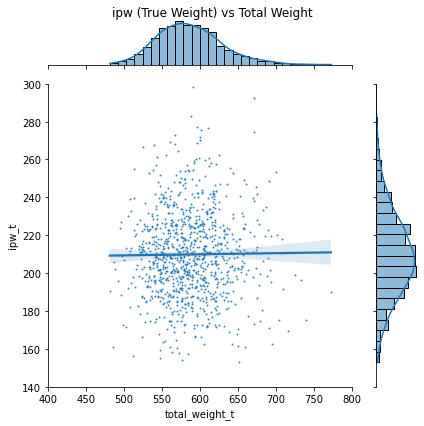

In [17]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='ipw_t', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('ipw (True Weight) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


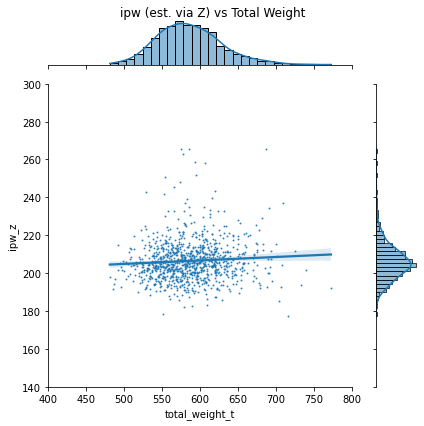

In [18]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='ipw_z', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('ipw (est. via Z) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


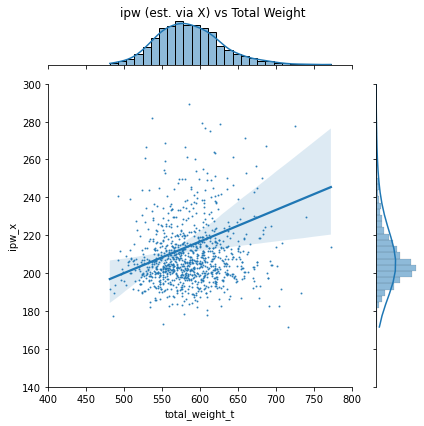

In [19]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='ipw_x', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('ipw (est. via X) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


### Self Normalized IPW

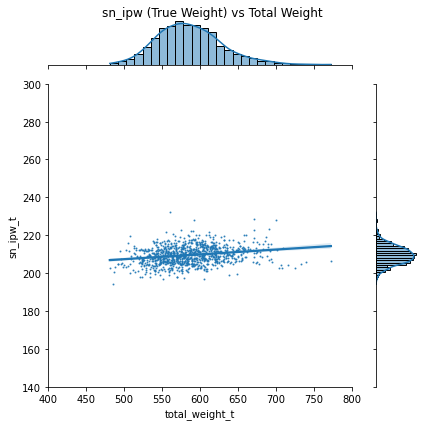

In [20]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='sn_ipw_t', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('sn_ipw (True Weight) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


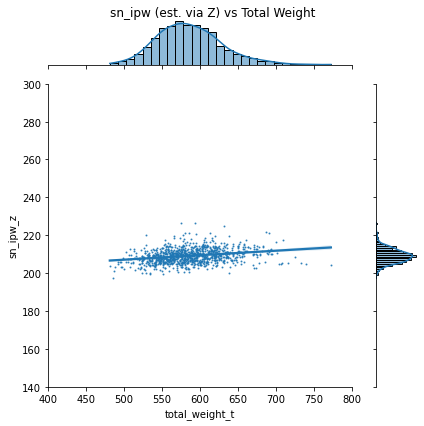

In [21]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='sn_ipw_z', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('sn_ipw (est. via Z) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


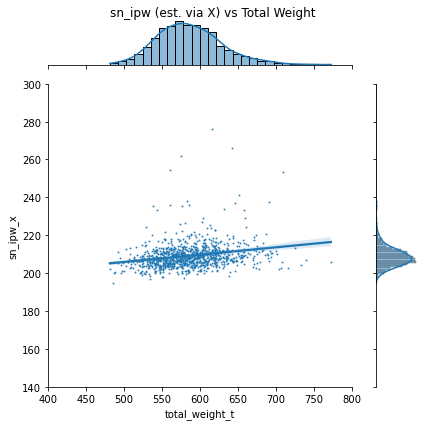

In [22]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='sn_ipw_x', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('sn_ipw (est. via X) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


In [23]:
print(max(results_df['total_weight_t']))
print(max(results_df['total_weight_z']))
print(max(results_df['total_weight_x']))

772.1158570704422
1660.300350607774
3970487.010350124


**PART B:** In this part we're going to try to get better performance using only the $x_i$'s for our propensity model.  Try using a nonlinear model (e.g. random forest, gradient boosted trees, etc...) to fit the propensity score function. Compare results using IPW and SN_IPW with both logistic regression and your nonlinear model for the propensity score function.  Summarize your findings.

In [24]:
@ignore_warnings(category=ConvergenceWarning)
def total_predicted_weight_x_only(s):
    #Create X and y for sklearn models
    #print('model_for_z')
    obs = s['obs']
    covariates=s[['x1','x2','x3','x4']]
    model = RandomForestClassifier()
    model.fit(X=covariates,y=obs)
    true_index = np.where(model.classes_ == True)[0][0]
    pred_prop_x_rf = model.predict_proba(X=covariates)[:,true_index]

    #print('model_for_x')

    obs = s['obs']
    covariates=s[['x1','x2','x3','x4']]
    model = GradientBoostingClassifier()
    model.fit(X=covariates,y=obs)
    true_index = np.where(model.classes_ == True)[0][0]
    pred_prop_x_gb = model.predict_proba(X=covariates)[:,true_index]
    
    return pred_prop_x_rf, pred_prop_x_gb


In [25]:
ipw_t_list = []
sn_ipw_t_list = []
total_weight_t_list = []
ipw_x_rf_list = []
sn_ipw_x_rf_list = []
total_weight_x_rf_list = []
ipw_x_gb_list = []
sn_ipw_x_gb_list = []
total_weight_x_gb_list = []
for ii in range(1000):
    sampler = KangSchafSampler(rng=default_rng())
    s = sampler.sample(n=200)
    
    pred_prop_x_rf, pred_prop_x_gb = total_predicted_weight_x_only(s)
    # True Weight
    result = ipw_estimators(s['obs_prob'],s['obs'],s['y'])
    ipw_t_list.append(result['ipw'])
    sn_ipw_t_list.append(result['sn_ipw'])
    total_weight_t_list.append(result['total_weight'])
    
    
     #Weight estimated from X (Random Forest)
    result = ipw_estimators(pd.Series(pred_prop_x_rf),s['obs'],s['y'])
    ipw_x_rf_list.append(result['ipw'])
    sn_ipw_x_rf_list.append(result['sn_ipw'])
    total_weight_x_rf_list.append(result['total_weight'])
    
    
    #Weight estimated from X (Gradient Boosting)
    result = ipw_estimators(pd.Series(pred_prop_x_gb),s['obs'],s['y'])
    ipw_x_gb_list.append(result['ipw'])
    sn_ipw_x_gb_list.append(result['sn_ipw'])
    total_weight_x_gb_list.append(result['total_weight'])
    
    
    
results_df = pd.DataFrame(
    {'ipw_t': ipw_t_list,
     'sn_ipw_t': sn_ipw_t_list,
     'total_weight_t': total_weight_t_list,
     'ipw_x_rf': ipw_x_rf_list,
     'sn_ipw_x_rf': sn_ipw_x_rf_list,
     'total_weight_x_rf': total_weight_x_rf_list,
     'ipw_x_gb': ipw_x_gb_list,
     'sn_ipw_x_gb': sn_ipw_x_gb_list,
     'total_weight_x_gb': total_weight_x_gb_list,
    })

In [37]:
results_df.describe()

,ipw_t,sn_ipw_t,total_weight_t,ipw_x_rf,sn_ipw_x_rf,total_weight_x_rf,ipw_x_gb,sn_ipw_x_gb,total_weight_x_gb
count,1000.000000,1000.000000,1000.000000,438.000000,438.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,210.228182,209.755495,585.744707,123.170512,201.603292,inf,122.284818,201.645746,1370.146127
std,23.723445,4.830988,46.723334,7.071136,3.165322,NaN,8.216634,3.390677,400.883548
min,151.038512,194.946411,464.544263,99.460435,192.314261,630.752556,95.188239,189.794127,614.497563
25%,193.440824,206.369692,552.918583,118.091303,199.324856,1215.255869,116.859425,199.417091,1090.724332
50%,208.943642,209.654231,581.539515,123.426385,201.799716,inf,122.481786,201.558537,1276.967769
75%,225.231903,212.706367,613.558135,128.388597,203.820028,inf,127.976202,203.901576,1550.940219
max,301.463624,228.069175,831.780251,142.717541,211.568278,inf,146.182007,212.777936,3350.368008


### IPW (not normalized)

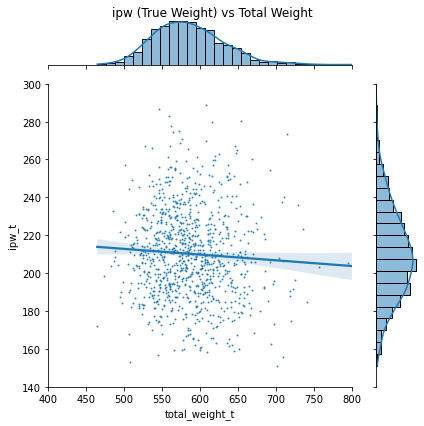

In [27]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='ipw_t', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('ipw (True Weight) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


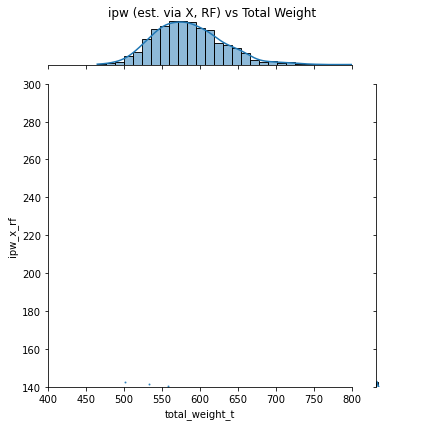

In [28]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='ipw_x_rf', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('ipw (est. via X, RF) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


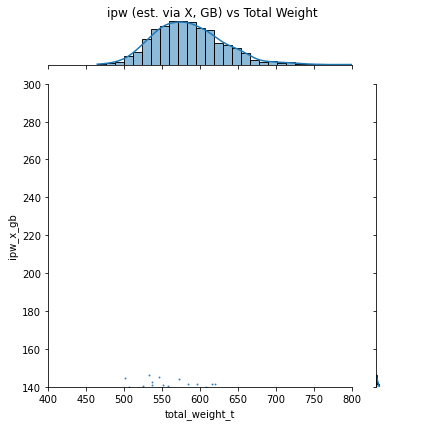

In [29]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='ipw_x_gb', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('ipw (est. via X, GB) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


### Self Normalized IPW 

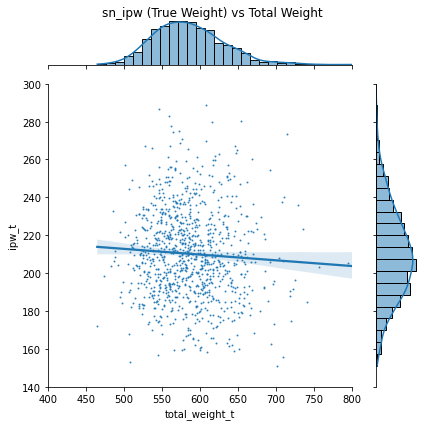

In [30]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='ipw_t', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('sn_ipw (True Weight) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


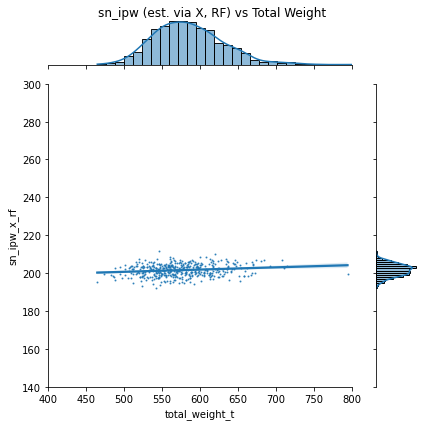

In [31]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='sn_ipw_x_rf', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('sn_ipw (est. via X, RF) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


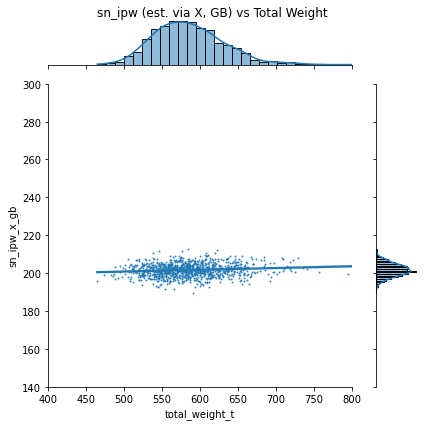

In [32]:
p = sns.jointplot(data=results_df, x='total_weight_t', y='sn_ipw_x_gb', kind="reg", x_jitter=0, scatter_kws={"s": 1})
plt.ylim(140, 300)
plt.xlim(400, 800)
p.fig.suptitle('sn_ipw (est. via X, GB) vs Total Weight')
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)
plt.show()


# Scratch below

In [33]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [34]:
sigmoid(-4)

NameError: name 'math' is not defined

In [ ]:
sigmoid(4)